In [1]:
import numpy as np
from matplotlib import pyplot as plt
from io import StringIO
import pandas as pd
from pathlib import Path
import seaborn as sns
from ccb.experiment import parse_results
from ccb.experiment.discriminative_metric import boostrap_pw_entropy
from ccb.experiment.retrieve_runs import retrieve_runs

%load_ext autoreload
%autoreload 2

# Main Restults

['resnet18' 'swinv2_tiny_window16_256' 'vit_small_patch16_224' 'resnet50'
 'conv4' 'millionaid_resnet50' 'ssl_moco_resnet50' 'ssl_moco_resnet18'
 'vit_tiny_patch16_224' 'convnext_base']


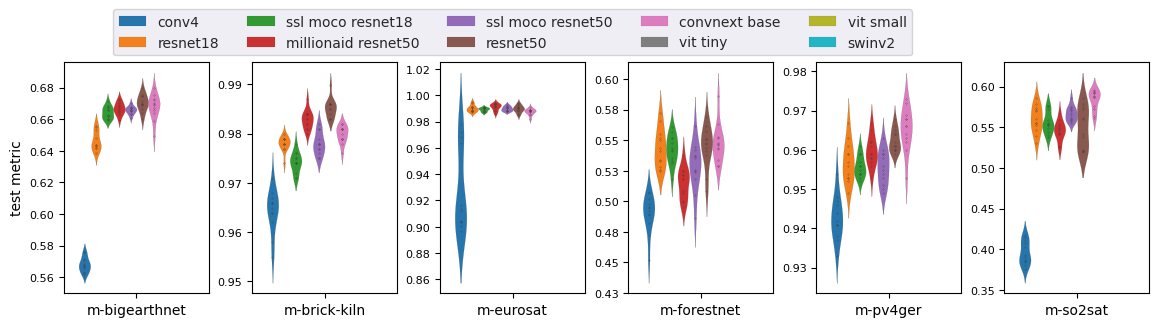

In [2]:
classification_dir = '/mnt/data/experiments/nils/final_classification_seeded_runs'

df = retrieve_runs(classification_dir, use_cached_csv=True, is_sweep=False)

print(df.model.unique())

# df['train_ratio'] = [get_train_ratio(part_name) for part_name in df['partition_name']]
df = df.applymap(parse_results.clean_names)
df = df.rename(columns=parse_results.clean_names)


model_order = "conv4,resnet18,ssl moco resnet18,millionaid resnet50,ssl moco resnet50,resnet50,convnext base,vit tiny,vit small,swinv2".split(",")
# df_1x = df[df['partition name'] == '1.00x train'].copy()
df_1x = df[(df["partition name"] == "1.00x train") | (df["partition name"] == "default")].copy()
normalizer = parse_results.make_normalizer(df_1x)
normalizer.normalize_data_frame(df_1x, ["test metric", "val metric"])

parse_results.plot_per_dataset_3(df_1x, model_order, metric="test metric", sharey=False, inner="points", fig_size=(14,3), n_legend_rows=2)
plt.savefig(Path.home() / "figures" / "test metric.pdf", bbox_inches="tight", dpi=300)
# parse_results.plot_per_dataset_3(df_1x, model_order, metric="val metric", sharey=False, inner="points")
# plt.savefig(Path.home() / "figures" / "test metric.png", bbox_inches="tight", dpi=300)

# parse_results.plot_per_dataset_3(df_1x, model_order, metric="test loss", sharey=False, inner="points")
# parse_results.plot_per_dataset_3(df_1x, model_order, metric="val loss", sharey=False, inner="points")


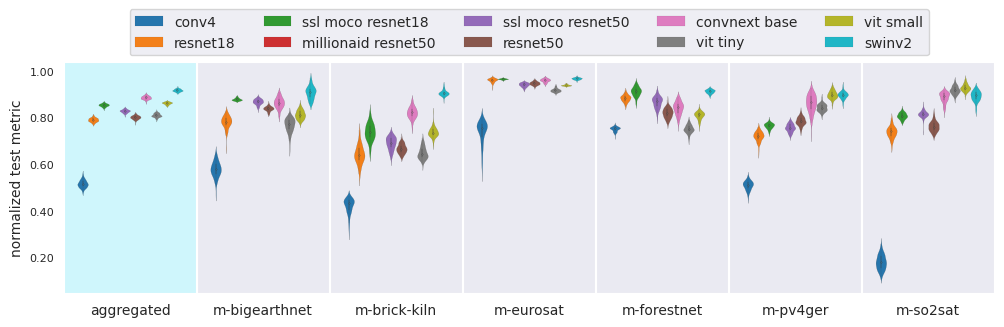

In [10]:
parse_results.plot_bootstrap_aggregate(df_1x, metric="normalized test metric", model_order=model_order, fig_size=(12,3))
# parse_results.plot_bootstrap_aggregate(df_1x, metric="normalized val_metric", model_order=model_order)
plt.savefig(Path.home() / "figures" / "normalized test metric.pdf", bbox_inches="tight", dpi=300)

# Train Size Analysis

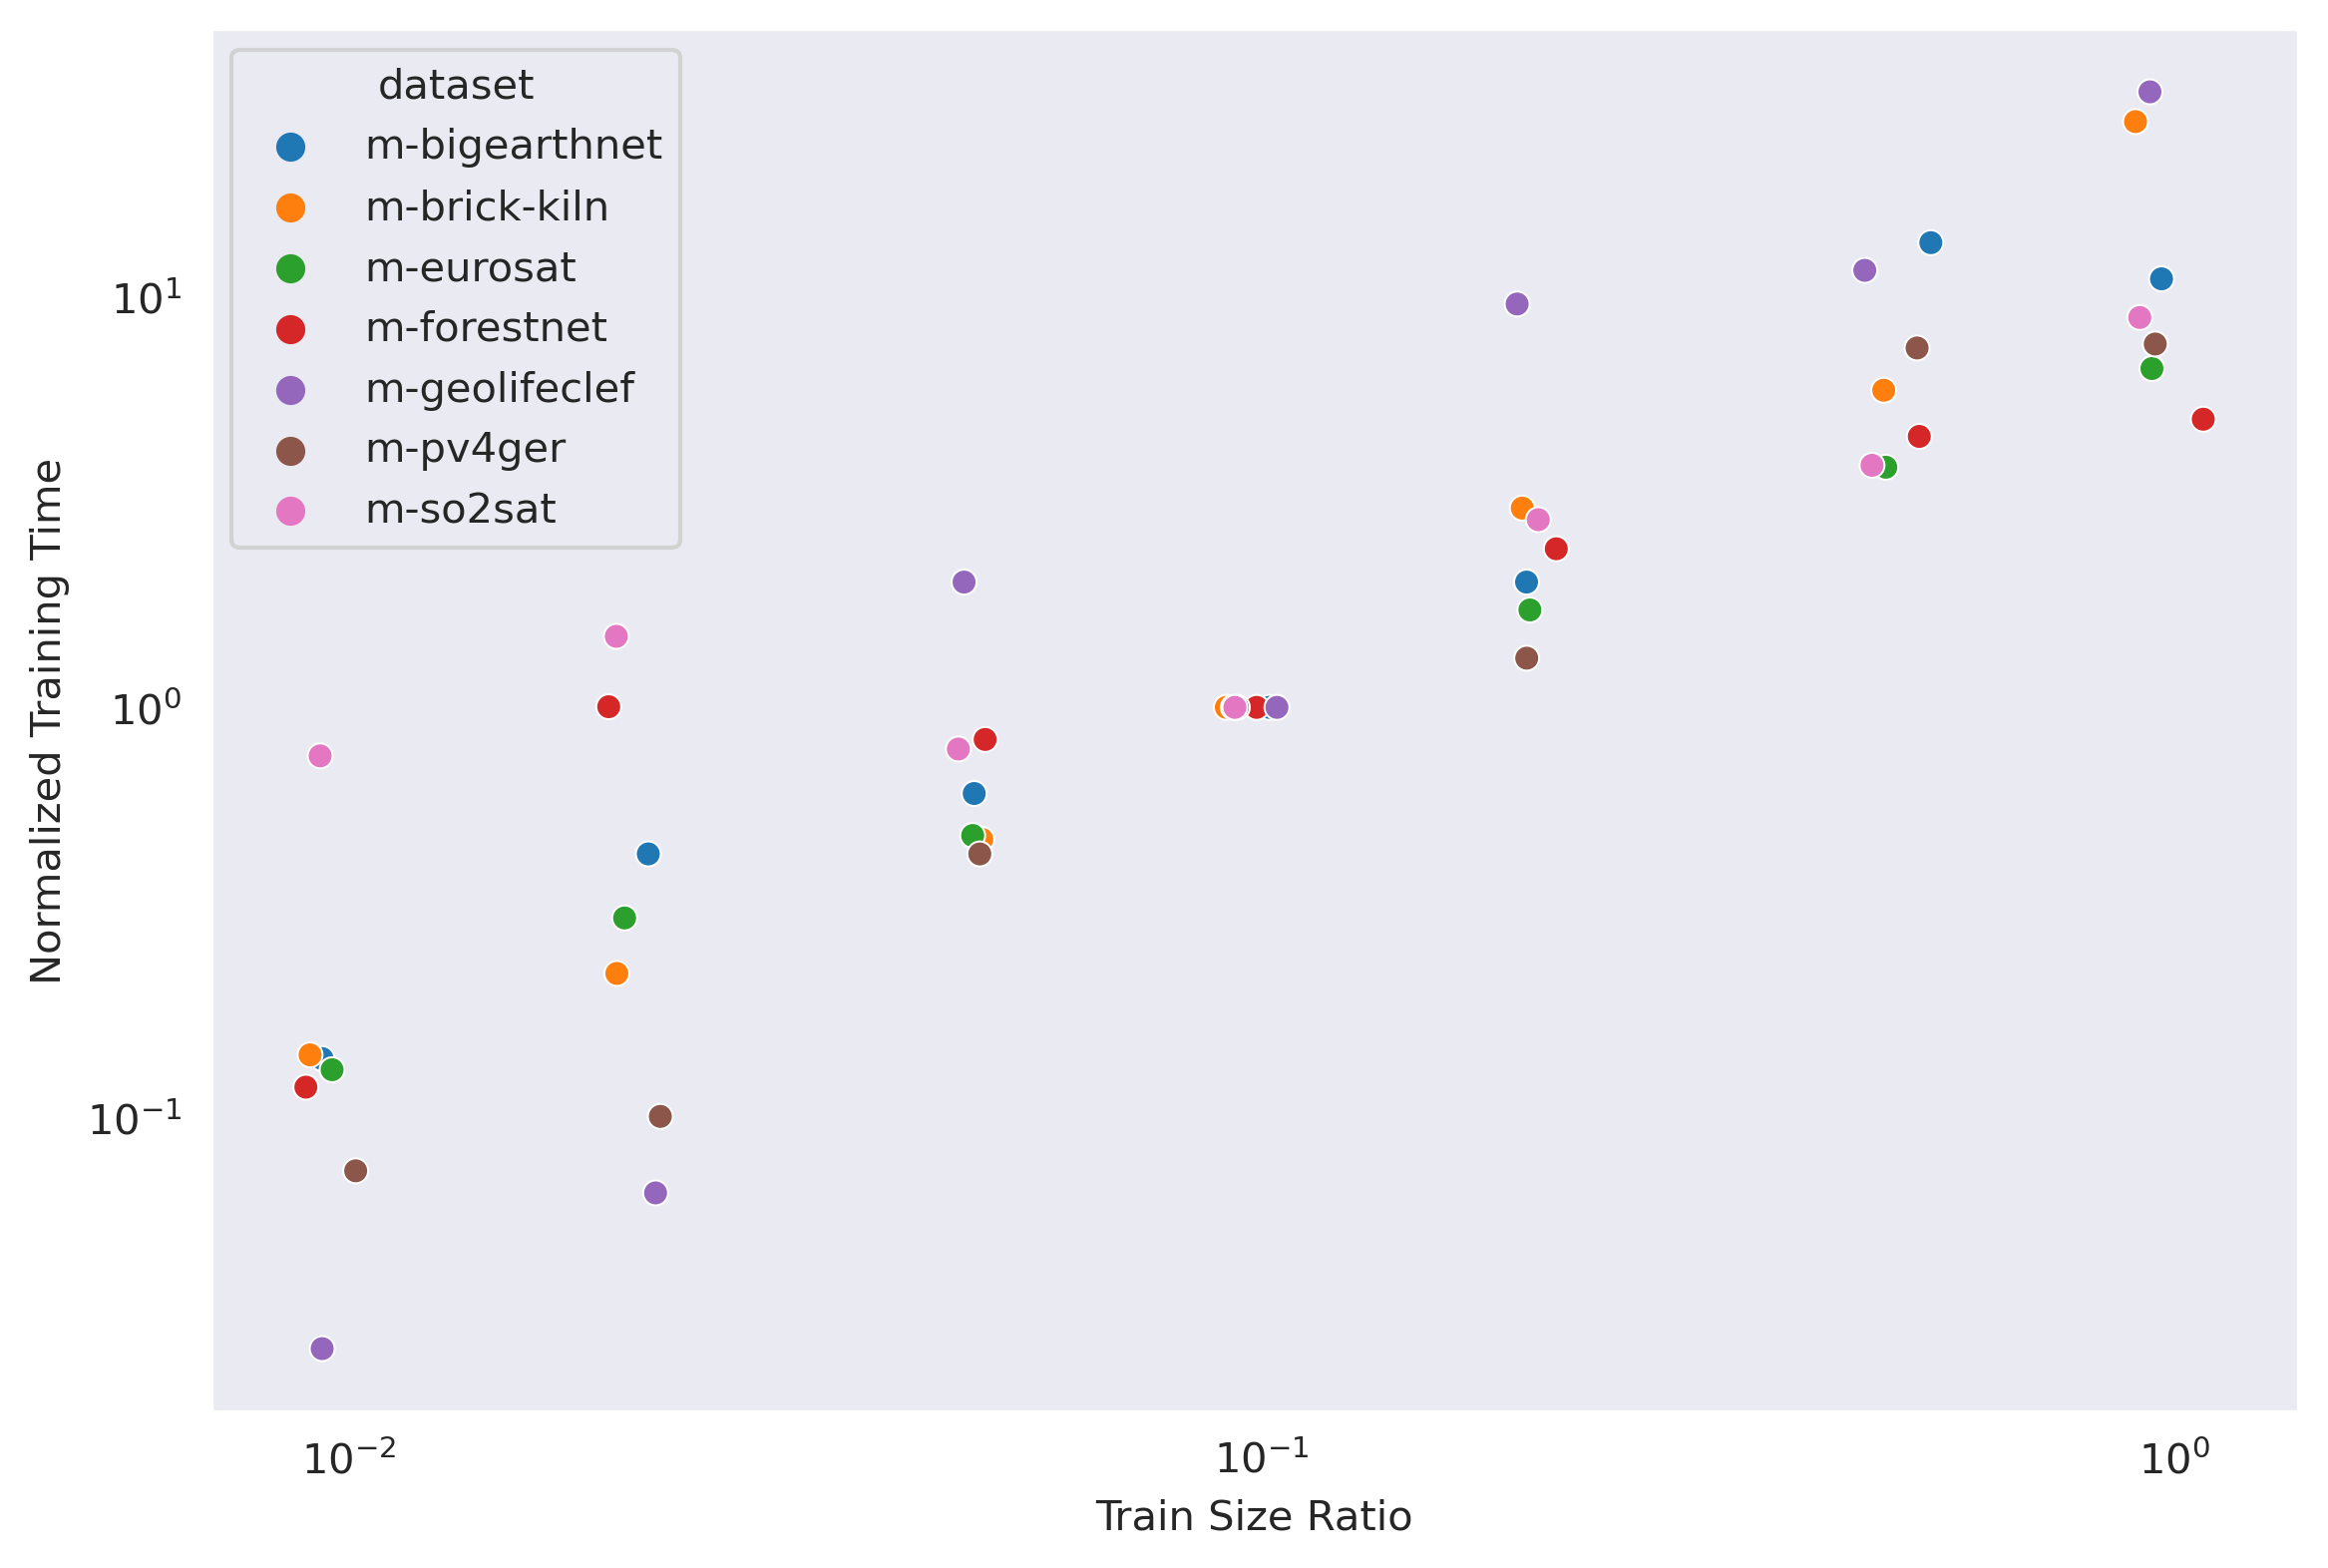

In [6]:
seeded_results_path = "/mnt/data/experiments/nils/classification_results/seeded_runs_2022-07-25_11-01-58.csv"
df = pd.read_csv(seeded_results_path)
df = df.applymap(parse_results.clean_names)
df = df.rename(columns=parse_results.clean_names)

plt.figure(figsize=(9,6), dpi=300)
parse_results.plot_normalized_time(df, average_seeds=True)
plt.savefig(Path.home() / "figures" / "training time.png", bbox_inches="tight")


m-so2sat
m-brick-kiln
m-eurosat
m-pv4ger
m-forestnet
m-bigearthnet
m-geolifeclef


<Figure size 1500x3000 with 0 Axes>

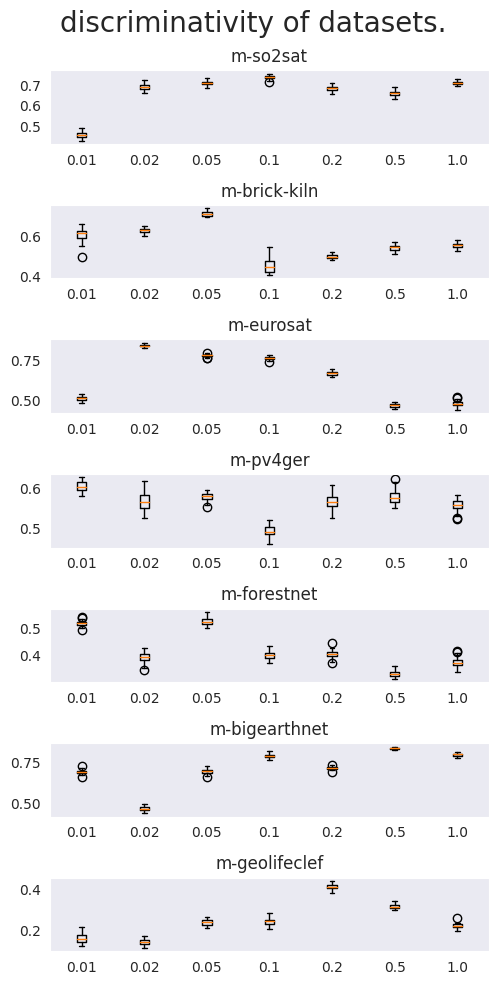

In [7]:
# old code, just keep it here for now.



def plot_discriminative_metric(df, metric="test metric", n_largest=3):
    models = df["model"].unique()
    datasets = df['dataset'].unique()
    train_ratios = np.sort(df['train ratio'].unique())

    fig, axes = plt.subplots( len(datasets), 1)
    fig.suptitle("discriminativity of datasets.", fontsize=20)
    

    for i, dataset in enumerate(datasets):

        print(dataset)
        discr_val = []
        for k, train_ratio in enumerate(train_ratios):

            # print(f"  train ratio : {train_ratio}")

            all_scores = []
            for j, model in enumerate(models):
                sub_df = df[(df["dataset"] == dataset) & (df['train ratio'] == train_ratio) & (df['model'] == model)]
                sub_df = sub_df.nlargest(n_largest, columns="val metric")
                scores = sub_df[metric].to_numpy()
                if len(scores) == 0:
                    print(f"  train ration: {train_ratio}: missing {model}")
                # print(f"    {j}: {scores}")
                all_scores.append(scores)
            
            # pw_entr = pairwise_entropy(all_scores)
            
            pw_entr_list = boostrap_pw_entropy(all_scores, repeat=50, std_ratio=0.2, replace=False)
            # print(f"    pw entr: {pw_entr}")
            axes[i].boxplot(1 - np.array(pw_entr_list), positions=[k])

            # discr_val.append(1 - pw_entr)
        
        axes[i].set_title(f"{dataset}")
        # axes[i].set_ylim((0.5,1))
        # axes[i].plot(np.arange(len(discr_val)), discr_val, marker='.')
        axes[i].set_xticklabels([str(trn_ratio) for trn_ratio in train_ratios])
    fig.tight_layout()


plt.figure(figsize=(5, 10), dpi=300)
plot_discriminative_metric(df, metric="val metric", n_largest=100)
plt.savefig(Path.home() / "figures" / "discriminativity.png", bbox_inches="tight")


In [21]:
df["partition name"].unique()

array(['1.00x train', '0.50x train', '0.20x train'], dtype=object)

In [3]:
for key, sub_df in df.groupby(["partition name", "model", "dataset"]):
    if len(sub_df) != 12:
        print(len(sub_df), key)


10 ('0.05x train', 'resnet50', 'm-eurosat')
11 ('0.10x train', 'resnet18', 'm-eurosat')
11 ('0.10x train', 'resnet50', 'm-brick-kiln')
11 ('0.20x train', 'swinv2-tiny', 'm-so2sat')
11 ('0.50x train', 'ssl moco resnet50', 'm-bigearthnet')
10 ('1.00x train', 'resnet18', 'm-bigearthnet')
10 ('1.00x train', 'swinv2-tiny', 'm-bigearthnet')
10 ('1.00x train', 'swinv2-tiny', 'm-brick-kiln')
10 ('1.00x train', 'swinv2-tiny', 'm-eurosat')
10 ('1.00x train', 'swinv2-tiny', 'm-forestnet')
10 ('1.00x train', 'swinv2-tiny', 'm-pv4ger')
10 ('1.00x train', 'swinv2-tiny', 'm-so2sat')


In [20]:
df.model.unique()

array(['resnet18', 'swinv2', 'vit small', 'resnet50', 'conv4',
       'millionaid resnet50', 'ssl moco resnet50', 'ssl moco resnet18',
       'vit tiny', 'convnext base'], dtype=object)

In [17]:
import glob
from pathlib import Path
classification_dir = '/mnt/data/experiments/nils/final_classification_seeded_runs'
# classification_dir =  '/mnt/data/experiments/nils/last_classification_sweeps'

path = str(Path(classification_dir) / "**" / "**"  / "**" / "csv_logs" / "**" / "config.yaml")
# path = str(Path(classification_dir) / "**" / "csv_logs" / "**" / "config.yaml")
dirs = glob.glob(path, recursive=False)
len(dirs)


1427

In [4]:
dirs

[]

In [8]:
parse_results.count_exp()

model                         conv4  convnext base  millionaid resnet50  \
dataset       partition name                                              
m-bigearthnet 0.05x train       NaN           12.0                  NaN   
              0.10x train       NaN           12.0                  NaN   
              0.20x train       NaN           12.0                  NaN   
              0.50x train      12.0           12.0                  NaN   
              1.00x train      12.0           12.0                 12.0   
m-brick-kiln  0.05x train       NaN           12.0                  NaN   
              0.10x train       NaN           12.0                  NaN   
              0.20x train       NaN           12.0                  NaN   
              0.50x train      12.0           12.0                  NaN   
              1.00x train      12.0           12.0                 12.0   
m-eurosat     0.05x train       NaN           12.0                  NaN   
              0.10x train       NaN           12.0                  NaN   
              0.20x train       NaN           12.0                  NaN   
              0.50x train      12.0           12.0                  NaN   
              1.00x train      12.0           12.0                 12.0   
m-forestnet   0.05x train       NaN           12.0                  NaN   
              0.10x train       NaN           12.0                  NaN   
              0.20x train       NaN           12.0                  NaN   
              0.50x train      12.0           12.0                  NaN   
              1.00x train      12.0           12.0                 12.0   
m-pv4ger      0.05x train       NaN           12.0                  NaN   
              0.10x train       NaN           12.0                  NaN   
              0.20x train       NaN           12.0                  NaN   
              0.50x train      12.0           12.0                  NaN   
              1.00x train      12.0           12.0                 12.0   
m-so2sat      0.05x train       NaN           12.0                  NaN   
              0.10x train       NaN           12.0                  NaN   
              0.20x train       NaN           12.0                  NaN   
              0.50x train      12.0           12.0                  NaN   
              1.00x train      12.0           12.0                 12.0   

model                         resnet18  resnet50  ssl moco resnet18  \
dataset       partition name                                          
m-bigearthnet 0.05x train         12.0      12.0                NaN   
              0.10x train         12.0      12.0                NaN   
              0.20x train         12.0      12.0                NaN   
              0.50x train         12.0      12.0               12.0   
              1.00x train         10.0      12.0               12.0   
m-brick-kiln  0.05x train         12.0      12.0                NaN   
              0.10x train         12.0      11.0                NaN   
              0.20x train         12.0      12.0                NaN   
              0.50x train         12.0      12.0               12.0   
              1.00x train         12.0      12.0               12.0   
m-eurosat     0.05x train         12.0      10.0                NaN   
              0.10x train         11.0      12.0                NaN   
              0.20x train         12.0      12.0                NaN   
              0.50x train         12.0      12.0               12.0   
              1.00x train         12.0      12.0               12.0   
m-forestnet   0.05x train         12.0      12.0                NaN   
              0.10x train         12.0      12.0                NaN   
              0.20x train         12.0      12.0                NaN   
              0.50x train         12.0      12.0               12.0   
              1.00x train         12.0      12.0               12.0   
m-pv4ger      0.05x train         12.